In [125]:
import gurobipy as gp
from gurobipy import GRB
import json
import pandas as pd
import numpy as np

In [126]:
with open(r"C:\Users\Pulin\Desktop\Optimisation_PowerSystems_Assignment1\data\question_1c\appliance_params.json", "r") as f:
    data = json.load(f)


In [127]:
data

{'DER': [{'DER_id': 'PV_01',
   'DER_type': 'PV',
   'max_power_kW': 3.0,
   'min_power_ratio': 0.0,
   'max_ramp_rate_up_ratio': 1.0,
   'max_ramp_rate_down_ratio': 1.0}],
 'load': [{'load_type': 'fully flexible load',
   'load_id': 'FFL_01',
   'max_load_kWh_per_hour': 3.0,
   'min_load_ratio': 0.0,
   'max_ramp_rate_up_ratio': 1.0,
   'max_ramp_rate_down_ratio': 1.0,
   'min_on_time_h': 0,
   'min_off_time_h': 0}],
 'storage': [{'storage_id': 'BESS_01',
   'storage_capacity_kWh': 6.0,
   'max_charging_power_ratio': 0.15,
   'max_discharging_power_ratio': 0.3,
   'charging_efficiency': 0.9,
   'discharging_efficiency': 0.9}]}

In [128]:
with open(r"C:\Users\Pulin\Desktop\Optimisation_PowerSystems_Assignment1\data\question_1c\bus_params.json", "r") as f:
    data2 = json.load(f)


In [129]:
data2

[{'bus_ID': 'Bus1',
  'import_tariff_DKK/kWh': 0.5,
  'export_tariff_DKK/kWh': 0.4,
  'max_import_kW': 1000,
  'max_export_kW': 500,
  'penalty_excess_import_DKK/kWh': 10,
  'penalty_excess_export_DKK/kWh': 10,
  'energy_price_DKK_per_kWh': [1.1,
   1.05,
   1.0,
   0.9,
   0.85,
   1.01,
   1.05,
   1.2,
   1.4,
   1.6,
   1.5,
   1.1,
   1.05,
   1.0,
   0.95,
   1.0,
   1.2,
   1.5,
   2.1,
   2.5,
   2.2,
   1.8,
   1.4,
   1.2]}]

In [130]:
with open(r"C:\Users\Pulin\Desktop\Optimisation_PowerSystems_Assignment1\data\question_1c\DER_production.json", "r") as f:
    data3 = json.load(f)

data3

[{'consumer_ID': 'C1',
  'DER_type': 'solar',
  'hourly_profile_ratio': [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.05,
   0.14,
   0.21,
   0.15,
   0.12,
   0.21,
   0.25,
   0.85,
   0.75,
   0.55,
   0.43,
   0.23,
   0.05,
   0.25,
   0.25,
   0.0,
   0.0,
   0.0,
   0.0]}]

In [131]:
def get_param(data, key, category=None, idx=0, subcategory=None, subidx=0):
    """
    General function to access a value from a (possibly nested) data dictionary.

    Args:
        data (dict or list): The loaded JSON dictionary or list of dicts.
        key (str): The key to access.
        category (str or None): The category (e.g., "DER", "load", "storage") if nested, else None.
        idx (int): Index in the list (default 0).
        subcategory (str or None): Optional subcategory key (e.g., "load_preferences").
        subidx (int): Index in the subcategory list (default 0).

    Returns:
        The value for the requested key, or None if not found.
    """
    try:
        if category and subcategory:
            return data[category][idx][subcategory][subidx][key]
        elif category:
            return data[category][idx][key]
        elif subcategory:
            return data[idx][subcategory][subidx][key]
        elif isinstance(data, list):
            return data[idx][key]
        else:
            return data[key]
    except (KeyError, IndexError, TypeError):
        print(f"Could not find {key} in the provided path.")
        return None

# Example usage:
# For data4 structure:
# get_param(data4, "hourly_profile_ratio", subcategory="load_preferences")

In [132]:
"Solar Power";
max_power_solar = get_param(data, "max_power_kW", category="DER")
min_power_ratio = get_param(data, "min_power_ratio", category="DER")
max_ramp_up_rate_solar  = get_param(data, "max_ramp_rate_up_ratio", category="DER")
max_ramp_down_rate_solar = get_param(data, "max_ramp_rate_down_ratio", category="DER")

#------------------------------------
"Flexible Load";
max_load_FFL = get_param(data, "max_load_kWh_per_hour", category="load")
min_load_FFL = get_param(data, "min_load_ratio", category="load")
max_ramp_up_rate_FFL = get_param(data, "max_ramp_rate_up_ratio", category="load")
max_ramp_down_rate_FFL = get_param(data, "max_ramp_rate_down_ratio", category="load")
min_on_time_h = get_param(data, "min_on_time_h", category="load")
min_off_time_h = get_param(data, "min_off_time_h", category="load")

#------------------------------------------------
"Battery Storage";
storage_capacity = get_param(data, "storage_capacity_kWh", category="storage")
max_charging_power_ratio = get_param(data, "max_charging_power_ratio", category="storage")
max_discharging_power_ratio = get_param(data, "max_discharging_power_ratio", category="storage")
charging_efficiency = get_param(data, "charging_efficiency", category="storage")
discharging_efficiency = get_param(data, "discharging_efficiency", category="storage")


In [133]:

price_import = get_param(data2, "import_tariff_DKK/kWh")  
price_export = get_param(data2, "export_tariff_DKK/kWh")  
max_import = get_param(data2, "max_import_kW")  
max_export = get_param(data2, "max_export_kW")  
penalty_excess_import = get_param(data2, "penalty_excess_import_DKK/kWh") 
penalty_excess_export = get_param(data2, "penalty_excess_export_DKK/kWh")  


electricity_price = get_param(data2, "energy_price_DKK_per_kWh")  

In [134]:
Solar_CF = get_param(data3,"hourly_profile_ratio")
Solar_CF

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.05,
 0.14,
 0.21,
 0.15,
 0.12,
 0.21,
 0.25,
 0.85,
 0.75,
 0.55,
 0.43,
 0.23,
 0.05,
 0.25,
 0.25,
 0.0,
 0.0,
 0.0,
 0.0]

In [135]:
with open(r"C:\Users\Pulin\Desktop\Optimisation_PowerSystems_Assignment1\data\question_1c\usage_preferences.json", "r") as f:
    data4 = json.load(f)

data4

[{'consumer_ID': 'C1',
  'grid_preferences': None,
  'DER_preferences': None,
  'load_preferences': [{'load_id': 'FFL_01',
    'min_total_energy_per_day_hour_equivalent': None,
    'max_total_energy_per_day_hour_equivalent': None,
    'hourly_profile_ratio': [0.055,
     0.04,
     0.04,
     0.04,
     0.075,
     0.48,
     0.76,
     0.8,
     0.63,
     0.22,
     0.25,
     0.35,
     0.3,
     0.28,
     0.45,
     0.65,
     0.78,
     0.9,
     0.98,
     0.88,
     0.075,
     0.15,
     0.075,
     0.055]}],
  'storage_preferences': [{'storage_id': 'BESS_01',
    'initial_soc_ratio': 0.5,
    'final_soc_ratio': 0.5}],
  'heat_pump_preferences': None}]

In [136]:
load_profile_consumer = get_param(data4, "hourly_profile_ratio", subcategory="load_preferences")
SOC_initial = get_param(data4, "initial_soc_ratio", subcategory="storage_preferences")
SOC_final = get_param(data4, "final_soc_ratio", subcategory="storage_preferences")


In [137]:
load_profile_consumer

[0.055,
 0.04,
 0.04,
 0.04,
 0.075,
 0.48,
 0.76,
 0.8,
 0.63,
 0.22,
 0.25,
 0.35,
 0.3,
 0.28,
 0.45,
 0.65,
 0.78,
 0.9,
 0.98,
 0.88,
 0.075,
 0.15,
 0.075,
 0.055]

In [138]:
SOC_initial, SOC_final

(0.5, 0.5)

In [139]:
max_charging_power_ratio, storage_capacity

(0.15, 6.0)

In [140]:
t = range(len(Solar_CF))
t

range(0, 24)

In [141]:
max_power_solar

3.0

In [142]:
SOC_initial

0.5

In [143]:
max_ramp_up_rate_FFL 

1.0

In [144]:
max_charging_power_ratio

0.15

In [145]:
storage_capacity

6.0

In [146]:
load_profile_consumer

[0.055,
 0.04,
 0.04,
 0.04,
 0.075,
 0.48,
 0.76,
 0.8,
 0.63,
 0.22,
 0.25,
 0.35,
 0.3,
 0.28,
 0.45,
 0.65,
 0.78,
 0.9,
 0.98,
 0.88,
 0.075,
 0.15,
 0.075,
 0.055]

In [147]:
max_load_FFL

3.0

In [148]:
import gurobipy as gp
from gurobipy import GRB

def prosumer_optimization(price_import, price_export, electricity_price,
                          penalty_excess_import, penalty_excess_export,weight_discomfort):
    """
    Prosumer optimization model to minimize procurement cost & penalties, including battery storage and SOC.
    """

    # Create model
    model = gp.Model("Prosumer_Continuous")

    # Decision variables
    x_imports = model.addVars(t, name="imported_power_kW", lb=0, ub=GRB.INFINITY)
    x_exports = model.addVars(t, name="exported_power_kW", lb=0, ub=GRB.INFINITY)
    x_FFL = model.addVars(t, name="FFL_consumption_kW", lb=0, ub=1)  # scaled 0-1
    x_solar = model.addVars(t, name="solar_power_kW", lb=0)
    z_import_excess = model.addVars(t, name="excess_import_kW", lb=0)
    z_export_excess = model.addVars(t, name="excess_export_kW", lb=0)
    delta_FFL = model.addVars(t, name="delta_FFL", lb=0, ub=GRB.INFINITY)
    SOC_t = model.addVars(t, name="SOC", lb=0, ub=storage_capacity)
    x_charging = model.addVars(t, name="charging_power_kW", lb=0, ub=max_charging_power_ratio * storage_capacity) 
    x_discharging = model.addVars(t, name="discharging_power_kW", lb=0, ub=max_discharging_power_ratio * storage_capacity)

    # Hourly constraints
    for i in t:
        # FFL min/max
        model.addConstr(x_FFL[i] * max_load_FFL >= min_load_FFL, name=f"FFL_min_{i}")
        model.addConstr(x_FFL[i] * max_load_FFL <= max_load_FFL, name=f"FFL_max_{i}")

        # Solar production limit
        model.addConstr(x_solar[i] <= Solar_CF[i] * max_power_solar, name=f"solar_max_{i}")

        # Energy balance (now includes battery charging/discharging)
        model.addConstr(
            x_imports[i] - x_exports[i] + x_solar[i] + x_discharging[i] - x_charging[i] == x_FFL[i] * max_load_FFL,
            name=f"energy_balance_{i}"
        )

        # Excess import/export
        model.addConstr(z_import_excess[i] >= x_imports[i] - max_import, name=f"excess_import_{i}")
        model.addConstr(z_export_excess[i] >= x_exports[i] - max_export, name=f"excess_export_{i}")

        #model.addConstr(x_charging[i] <= max_charging_power_ratio * storage_capacity, name=f"charging_limit_{i}")
        #model.addConstr(x_discharging[i] <= max_discharging_power_ratio * storage_capacity, name=f"discharging_limit_{i}")

        # Discomfort per hour from load profile
        model.addConstr(delta_FFL[i] >= (x_FFL[i] - load_profile_consumer[i]) * max_load_FFL, name=f"discomfort_pos_{i}")
        model.addConstr(delta_FFL[i] >= (load_profile_consumer[i] - x_FFL[i]) * max_load_FFL, name=f"discomfort_neg_{i}")

        #model.addConstr(x_FFL[i] == load_profile_consumer[i]) 
     
        # SOC bounds and dynamics
        if i == 0:
            model.addConstr(SOC_t[i] == SOC_initial * storage_capacity, name="initial_soc") # kWh
        if i == 24:
            model.addConstr(SOC_t[i] == SOC_final * storage_capacity, name="final_soc") # kWh

        # Final SOC constraint (at last hour)
        if i == t[-1]:
            model.addConstr(SOC_t[i] == SOC_final * storage_capacity, name="final_soc") # kWh

        # Ramp constraints for FFL + Solar,  [t - 1] -> [t]
        if i > 0:
            model.addConstr(
                (x_FFL[i] * max_load_FFL) - (x_FFL[i-1] * max_load_FFL) <= max_ramp_up_rate_FFL * max_load_FFL,
                name=f"FFL_ramp_up_{i}"
            )
            model.addConstr(
                (x_FFL[i-1] * max_load_FFL) - (x_FFL[i] * max_load_FFL) <= max_ramp_down_rate_FFL * max_load_FFL,
                name=f"FFL_ramp_down_{i}"
            )

            # Ramp constraints for solar
            model.addConstr(
                x_solar[i] - x_solar[i-1] <= max_ramp_up_rate_solar * max_power_solar,
                name=f"solar_ramp_up_{i}"
            )
            model.addConstr(
                x_solar[i-1] - x_solar[i] <= max_ramp_down_rate_solar * max_power_solar,
                name=f"solar_ramp_down_{i}"
            )
    

            # SOC dynamics
            model.addConstr(
                SOC_t[i] == SOC_t[i-1] + (x_charging[i - 1] * charging_efficiency) - (x_discharging[i - 1] / discharging_efficiency),
                name=f"SOC_dynamics_{i}"
            )

            

        
# Minimum total daily FFL energy
    model.addConstr(    
    gp.quicksum(x_FFL[i] * max_load_FFL for i in t) >= 0 * max_load_FFL,
    name="FFL_min_total_energy"
)
            

    # Objective: minimize cost + penalties
    model.setObjective(
    gp.quicksum(
        (-price_import - electricity_price[i]) * x_imports[i]
        - penalty_excess_import * z_import_excess[i]
        + (electricity_price[i] - price_export) * x_exports[i]
        -penalty_excess_export * z_export_excess[i] - weight_discomfort*delta_FFL[i]  # Penalty for discomfort
        for i in t
    ),
    sense=GRB.MAXIMIZE
)

    # Solve
    model.optimize()

    return model, x_imports, x_exports, x_FFL, x_solar, delta_FFL, SOC_t, x_charging, x_discharging

In [149]:
price_import, price_export,penalty_excess_import, penalty_excess_export

(0.5, 0.4, 10, 10)

In [181]:
# Run the optimization and get the variables
model, x_imports, x_exports, x_FFL, x_solar, delta_FFL, SOC_t, x_charging, x_discharging = prosumer_optimization(
    price_import, price_export, electricity_price,
    penalty_excess_import, penalty_excess_export, weight_discomfort=2)

# Print all outputs per hour
print("Hour | Import(kW) | Export(kW) | FFL(kW) | Solar(kW) | Delta_FFL | SOC(kWh) | Charging(kW) | Discharging(kW)")
for i in t:
    print(f"{i:>4} | "
          f"{x_imports[i].X:>10.3f} | "
          f"{x_exports[i].X:>10.3f} | "
          f"{x_FFL[i].X * max_load_FFL:>7.3f} | "
          f"{x_solar[i].X:>8.3f} | "
          f"{delta_FFL[i].X:>9.3f} | "
          f"{SOC_t[i].X:>8.3f} | "
          f"{x_charging[i].X:>11.3f} | "
          f"{x_discharging[i].X:>13.3f}")

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 8845HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 310 rows, 240 columns and 710 nonzeros
Model fingerprint: 0xb82a5505
Coefficient statistics:
  Matrix range     [9e-01, 3e+00]
  Objective range  [4e-01, 1e+01]
  Bounds range     [9e-01, 6e+00]
  RHS range        [1e-01, 1e+03]
Presolve removed 169 rows and 14 columns
Presolve time: 0.01s
Presolved: 141 rows, 226 columns, 412 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2060000e+31   4.055000e+31   2.206000e+01      0s


     121   -2.5537094e+01   0.000000e+00   0.000000e+00      0s

Solved in 121 iterations and 0.02 seconds (0.00 work units)
Optimal objective -2.553709444e+01
Hour | Import(kW) | Export(kW) | FFL(kW) | Solar(kW) | Delta_FFL | SOC(kWh) | Charging(kW) | Discharging(kW)
   0 |      0.165 |      0.000 |   0.165 |    0.000 |     0.000 |    3.000 |       0.000 |         0.000
   1 |      0.120 |      0.000 |   0.120 |    0.000 |     0.000 |    3.000 |       0.000 |         0.000
   2 |      0.350 |      0.000 |   0.120 |    0.000 |     0.000 |    3.000 |       0.230 |         0.000
   3 |      1.020 |      0.000 |   0.120 |    0.000 |     0.000 |    3.207 |       0.900 |         0.000
   4 |      1.125 |      0.000 |   0.225 |    0.000 |     0.000 |    4.017 |       0.900 |         0.000
   5 |      1.290 |      0.000 |   1.440 |    0.150 |     0.000 |    4.827 |       0.000 |         0.000
   6 |      1.860 |      0.000 |   2.280 |    0.420 |     0.000 |    4.827 |       0.000 |         0.

In [182]:
np.array(Solar_CF)*max_power_solar

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.15, 0.42, 0.63, 0.45, 0.36, 0.63,
       0.75, 2.55, 2.25, 1.65, 1.29, 0.69, 0.15, 0.75, 0.75, 0.  , 0.  ,
       0.  , 0.  ])

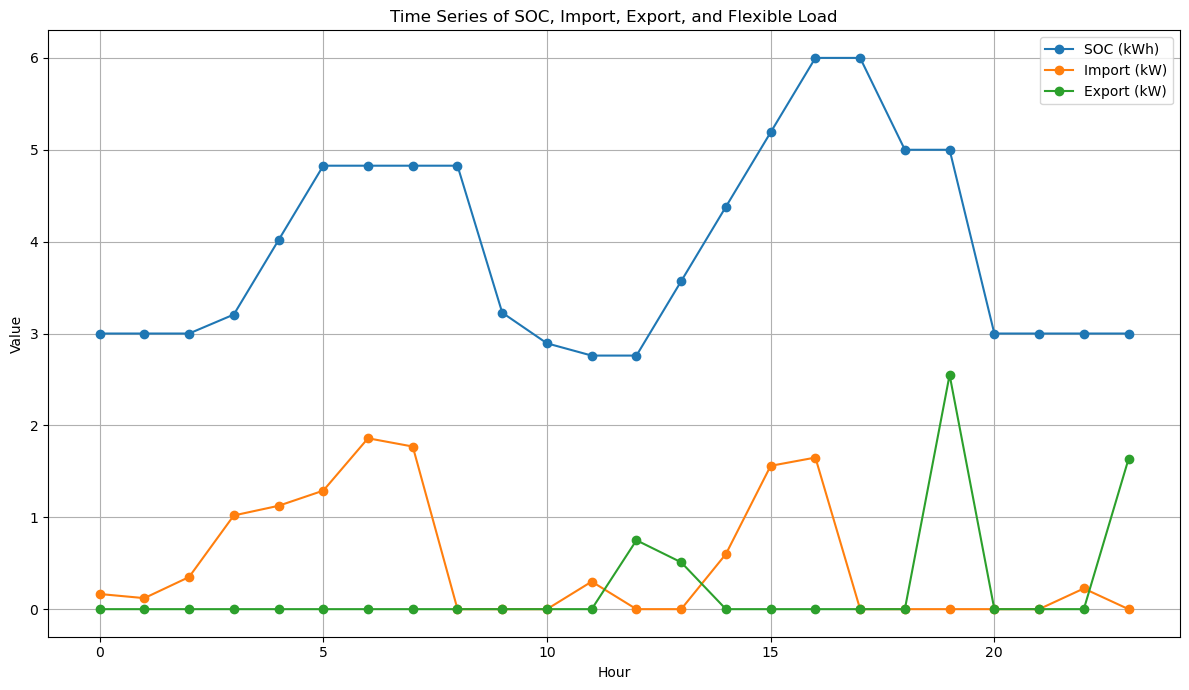

In [183]:
import matplotlib.pyplot as plt

# Extract results after optimization
hours = list(t)
soc = [SOC_t[i].X for i in hours]
imports = [x_imports[i].X for i in hours]
exports = [x_exports[i].X for i in hours]
discomfort = [delta_FFL[i].X for i in hours]
actual_profile = [x_FFL[i].X * max_FFL for i in hours]
solar_production = [x_solar[i].X for i in hours]


plt.figure(figsize=(12, 7))
plt.plot(hours, soc, label="SOC (kWh)", marker='o')
plt.plot(hours, imports, label="Import (kW)", marker='o')
plt.plot(hours, exports, label="Export (kW)", marker='o')
#plt.plot(hours, ffl, label="Flexible Load (kW)", marker='o')
#plt.plot(hours, discomfort, label="Discomfort (kW)", marker='o')
#plt.plot(hours, max_FFL*np.array(hourly_profile), label="Desired Load Profile (kW)", marker = "*", color='red')
#plt.plot(hours, np.array(actual_profile), label="Actual Load Profile (kW)", linestyle='--', color='blue')
plt.xlabel("Hour")
plt.ylabel("Value")
plt.title("Time Series of SOC, Import, Export, and Flexible Load")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

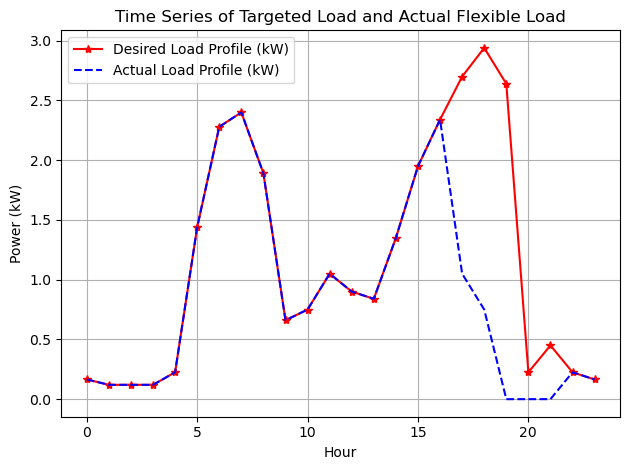

In [184]:
plt.plot(hours, max_load_FFL*np.array(load_profile_consumer), label="Desired Load Profile (kW)", marker = "*", color='red')
plt.plot(hours, np.array(actual_profile), label="Actual Load Profile (kW)", linestyle='--', color='blue')
plt.xlabel("Hour")
plt.ylabel("Power (kW)")
plt.title("Time Series of Targeted Load and Actual Flexible Load")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Time Series of Absolute Discomfort')

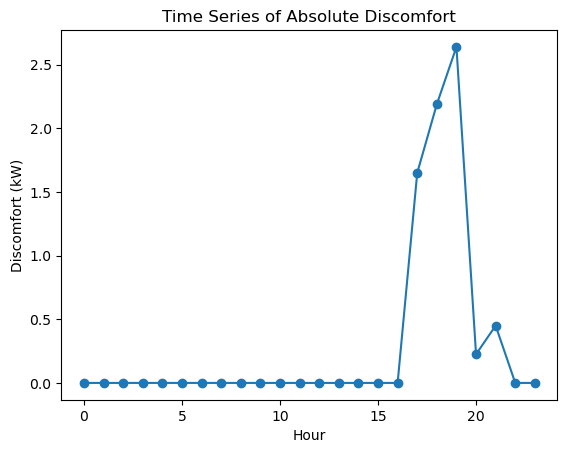

In [185]:
plt.plot(hours, discomfort, label="Discomfort (kW)", marker='o')
plt.xlabel("Hour")
plt.ylabel("Discomfort (kW)")
plt.title("Time Series of Absolute Discomfort")

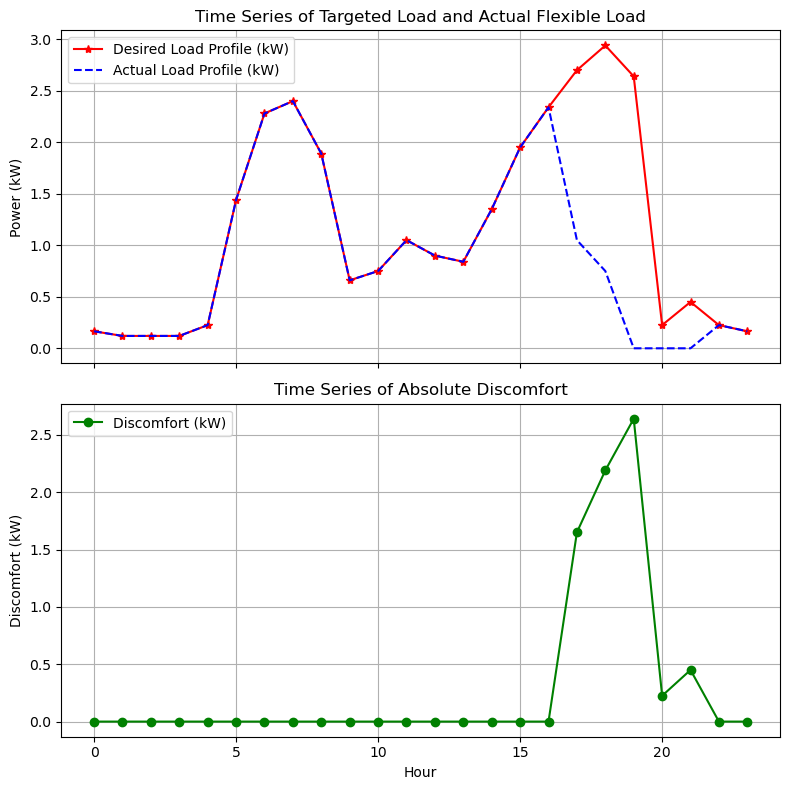

In [186]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# --- First subplot: Load profiles ---
axs[0].plot(hours, max_load_FFL*np.array(load_profile_consumer), 
            label="Desired Load Profile (kW)", marker="*", color='red')
axs[0].plot(hours, np.array(actual_profile), 
            label="Actual Load Profile (kW)", linestyle='--', color='blue')
axs[0].set_ylabel("Power (kW)")
axs[0].set_title("Time Series of Targeted Load and Actual Flexible Load")
axs[0].legend()
axs[0].grid(True)

# --- Second subplot: Discomfort ---
axs[1].plot(hours, discomfort, label="Discomfort (kW)", marker='o', color='green')
axs[1].set_xlabel("Hour")
axs[1].set_ylabel("Discomfort (kW)")
axs[1].set_title("Time Series of Absolute Discomfort")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


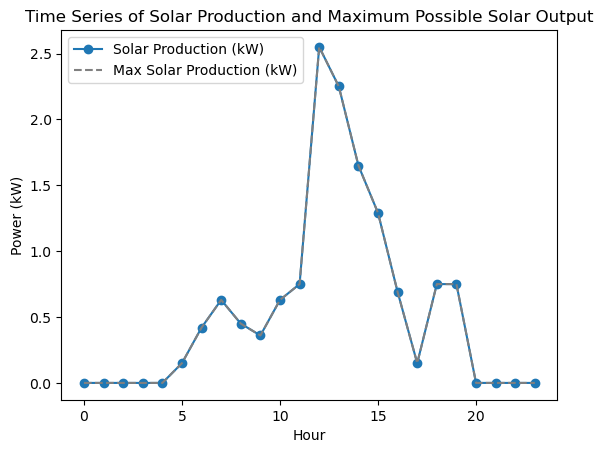

In [187]:
plt.plot(hours, solar_production, label="Solar Production (kW)", marker='o')
plt.plot(hours, np.array(Solar_CF)* max_power_solar, label="Max Solar Production (kW)", linestyle='--', color='gray')
plt.xlabel("Hour")
plt.ylabel("Power (kW)")
plt.title("Time Series of Solar Production and Maximum Possible Solar Output")
plt.legend()

In [188]:
np.array(load_profile_consumer)*max_FFL

array([0.165, 0.12 , 0.12 , 0.12 , 0.225, 1.44 , 2.28 , 2.4  , 1.89 ,
       0.66 , 0.75 , 1.05 , 0.9  , 0.84 , 1.35 , 1.95 , 2.34 , 2.7  ,
       2.94 , 2.64 , 0.225, 0.45 , 0.225, 0.165])

In [189]:
np.array(actual_profile)

array([0.165, 0.12 , 0.12 , 0.12 , 0.225, 1.44 , 2.28 , 2.4  , 1.89 ,
       0.66 , 0.75 , 1.05 , 0.9  , 0.84 , 1.35 , 1.95 , 2.34 , 1.05 ,
       0.75 , 0.   , 0.   , 0.   , 0.225, 0.165])